<a href="https://colab.research.google.com/github/ykitaguchi77/YOLACT_Mobius/blob/main/Mobius2label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mobius2label**

Mobiusのカラーマスク→ YOLOv8 instance trainingトレーニング用の座標に

研究室配属 鈴木くんより

In [1]:
#@title #ライブラリのインストール
#@markdown [shift]+[Enter]を押して起動してください
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import json
from tqdm import tqdm  # tqdmをインポート
import os
import matplotlib

Mounted at /content/drive


In [2]:
#@title #ディレクトリと座標の個数
#@markdown 指定を終えてから、[shift]+[Enter]を押して起動してください。
#@markdown <br> 学習に適切な個数が分からなかったので、変更できるようにしました。

# 入力ディレクトリと出力ディレクトリを指定してください
input_dir = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/Masks/1"
output_dir = "/content"

# eyelid, iris, pupilごとに座標の個数を指定してください。
num_points_eyelid = 24
num_points_iris = 16
num_points_pupil = 12

In [ ]:
#@title #Mobius to label起動
#@markdown 　[shift]+[Enter]を押して起動してください。
#@markdown　<br>うまくいっていないラベルも存在するので、目視で確認して除外すべきかもしれません。
def create_mask(image, color):
    return np.all(image == color, axis=-1)

def apply_mask(image, mask):
    return np.where(mask, 255, 0)

def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list

def create_custom_output(points_list_blue, points_list_blue_green, points_list_all_colors, img_width, img_height, output_file):
    with open(output_file, 'w') as f:
        # 0: eyelid
        f.write("0 ")
        for point in points_list_all_colors[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x} {y} ")
        f.write("\n")

        # 1: iris
        f.write("1 ")
        for point in points_list_blue_green[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x} {y} ")
        f.write("\n")

        # 2: pupil
        f.write("2 ")
        for point in points_list_blue[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x} {y} ")
        f.write("\n")

def process_image(mask_file, output_dir, num_points_eyelid, num_points_iris, num_points_pupil):
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    # 各ラベルごとに異なる個数の座標を抽出
    points_list_blue = extract_contours(img_blue, num_points_pupil)
    points_list_blue_green = extract_contours(img_blue_green, num_points_iris)
    points_list_all_colors = extract_contours(img_all_colors, num_points_eyelid)

    # 出力先ディレクトリとファイル名を設定
    base_name = os.path.splitext(os.path.basename(mask_file))[0]
    output_file = os.path.join(output_dir, base_name + ".txt")

    # カスタム出力
    create_custom_output(points_list_blue, points_list_blue_green, points_list_all_colors, img_width, img_height, output_file)

    # 書き換え部分
    x_eyelid = [point[0] for point in points_list_all_colors[0]]
    y_eyelid = [point[1] for point in points_list_all_colors[0]]

    x_iris = [point[0] for point in points_list_blue_green[0]]
    y_iris = [point[1] for point in points_list_blue_green[0]]

    x_pupil = [point[0] for point in points_list_blue[0]]
    y_pupil = [point[1] for point in points_list_blue[0]]

    # 元の画像を読み込む
    img_path = mask_file.replace("Masks", "Images").replace(".png", ".jpg")
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # プロット作成
    plt.figure(figsize=(12, 6))

    # 左側に元の画像を表示
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(base_name)  # ファイル名をタイトルに設定

    # 右側に散布図を表示
    plt.subplot(1, 2, 2)
    plt.scatter(x_eyelid, y_eyelid, label='eyelid', color='blue')
    plt.scatter(x_iris, y_iris, label='iris', color='green')
    plt.scatter(x_pupil, y_pupil, label='pupil', color='red')
    plt.title("Contours")  # 輪郭

    # 軸を画像の大きさに合わせて調整
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])  # Y軸の反転

    # 縦横の比率を保つ
    plt.gca().set_aspect('equal', adjustable='box')

    # 凡例を表示する
    plt.legend()

    # レイアウトを調整して表示
    plt.tight_layout()
    plt.show()





def process_all_images_in_directory(input_dir, output_dir, num_points_eyelid, num_points_iris, num_points_pupil):
    # 入力ディレクトリ内のすべての.pngファイルを処理
    png_files = [file_name for file_name in os.listdir(input_dir) if file_name.endswith(".png")]

    # tqdmを使って進行状況を表示
    for file_name in tqdm(png_files, desc="Processing images"):
        mask_file = os.path.join(input_dir, file_name)
        process_image(mask_file, output_dir, num_points_eyelid, num_points_iris, num_points_pupil)



if __name__ == '__main__':
    process_all_images_in_directory(input_dir, output_dir, num_points_eyelid, num_points_iris, num_points_pupil)


###一つだけの画像バージョン（テスト用）

# 備考欄

## ラベルの構造

0 x1 y1 x2 y2 x3 y3...(eyelidの座標)<br>
1 x1 y1 x2 y2 x3 y3...(irisの座標)<br>
2 x1 y1 x2 y2 x3 y3...(pupilの座標)

#**Preprocess dataset for YOLOv8 insyance segmentation training**

To do：

Mobiusのマスク画像をYOLOv8形式のテキストファイルに

マスク画像がない画像を除外

Not goodの画像を除外

YOLOv8用のフォルダ構成に

Yolov8のtraining

マスク画像がない画像をinference

手動で選別しOKのものを追加し再学習

In [ ]:
"""
project/
│
├── data/
│   ├── train/
│   │   ├── images/
│   │   └── labels/
│   │
│   ├── val/
│   │   ├── images/
│   │   └── labels/
│   │
│   └── test/  (オプション)
│       ├── images/
│       └── labels/
│
│
├── dataset.yaml
│
├── models/
│
└── runs/  (トレーニング結果が保存される)
"""

###Mask2label for YOLOv8 training




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Processing folder 2:  42%|████▏     | 60/144 [04:20<06:42,  4.79s/it]

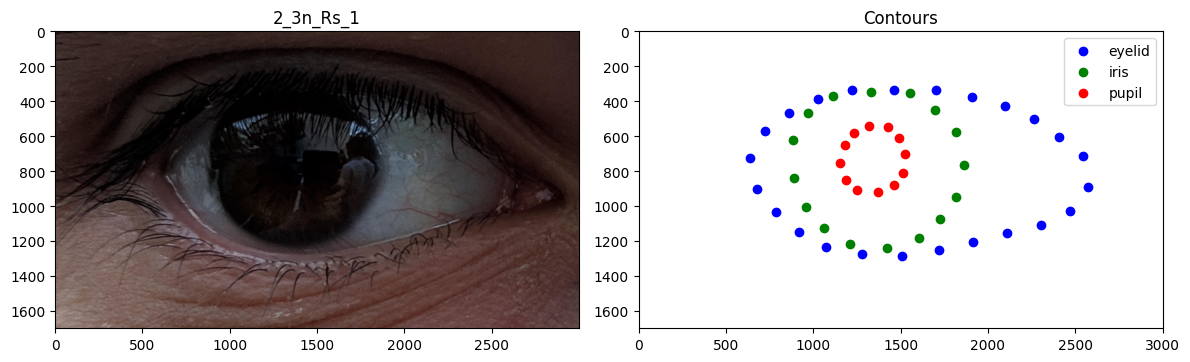

Processing folder 2:  42%|████▏     | 61/144 [04:24<06:25,  4.64s/it]

In [ ]:
"""
このスクリプトは、Mobiusデータセットの画像とマスクをYOLOv8形式に変換します。

主な機能：
1. Masksディレクトリ内の全てのマスク画像を処理（フォルダ番号順）
2. 各マスクに対応するYOLOv8形式のラベルファイルを生成
3. 対応する前眼部画像を指定された出力ディレクトリにコピー
4. 処理中に画像とマスクのプロットを表示
5. tqdmを使用して処理の進捗を表示
6. 開始フォルダを指定可能

入力ディレクトリ構造：
- Masks: /content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/Masks/
  - 1/
  - 2/
  ...
  - 35/
- Images: /content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/Images/
  - 1/
  - 2/
  ...
  - 35/

出力ディレクトリ構造：
- Labels: /content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training/labels/
- Images: /content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training/images/

注意：
- 出力ディレクトリが存在しない場合は自動的に作成されます
- マスクの色に基づいて、瞼（赤）、虹彩（緑）、瞳孔（青）を識別します
- 各部位の座標点の数は変数で設定可能です（デフォルト：瞼24点、虹彩16点、瞳孔12点）
- フォルダは番号順に処理されます
- 開始フォルダ番号を指定できます
"""

import os
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

def create_mask(image, color):
    """
    指定された色に基づいてマスクを作成します。

    Args:
    image (np.array): 入力画像
    color (list): マスクを作成する色 [R, G, B]

    Returns:
    np.array: 指定された色に対するバイナリマスク
    """
    return np.all(image == color, axis=-1)

def apply_mask(image, mask):
    """
    画像にマスクを適用します。

    Args:
    image (np.array): 入力画像
    mask (np.array): バイナリマスク

    Returns:
    np.array: マスクが適用された画像
    """
    return np.where(mask, 255, 0)

def extract_contours(img, _num_points):
    """
    画像から輪郭を抽出し、指定された数の点を選択します。

    Args:
    img (np.array): 入力画像
    _num_points (int): 選択する点の数

    Returns:
    list: 選択された点のリスト
    """
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list

def create_yolov8_output(points_list_blue, points_list_blue_green, points_list_all_colors, img_width, img_height, output_file):
    """
    YOLOv8形式のラベルファイルを作成します。

    Args:
    points_list_blue (list): 瞳孔の点のリスト
    points_list_blue_green (list): 虹彩の点のリスト
    points_list_all_colors (list): 瞼の点のリスト
    img_width (int): 画像の幅
    img_height (int): 画像の高さ
    output_file (str): 出力ファイルのパス
    """
    with open(output_file, 'w') as f:
        # 0: eyelid
        f.write("0 ")
        for point in points_list_all_colors[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x:.6f} {y:.6f} ")
        f.write("\n")

        # 1: iris
        f.write("1 ")
        for point in points_list_blue_green[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x:.6f} {y:.6f} ")
        f.write("\n")

        # 2: pupil
        f.write("2 ")
        for point in points_list_blue[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x:.6f} {y:.6f} ")
        f.write("\n")

def process_image(mask_file, images_dir, output_labels_dir, output_images_dir, num_points_eyelid, num_points_iris, num_points_pupil):
    """
    1つのマスク画像を処理し、対応するラベルファイルを生成し、元の画像をコピーします。

    Args:
    mask_file (str): マスク画像のファイルパス
    images_dir (str): 元の画像が格納されているディレクトリ
    output_labels_dir (str): ラベルファイルの出力ディレクトリ
    output_images_dir (str): 画像のコピー先ディレクトリ
    num_points_eyelid (int): 瞼の点の数
    num_points_iris (int): 虹彩の点の数
    num_points_pupil (int): 瞳孔の点の数
    """
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    points_list_blue = extract_contours(img_blue, num_points_pupil)
    points_list_blue_green = extract_contours(img_blue_green, num_points_iris)
    points_list_all_colors = extract_contours(img_all_colors, num_points_eyelid)

    base_name = os.path.splitext(os.path.basename(mask_file))[0]
    output_file = os.path.join(output_labels_dir, base_name + ".txt")

    create_yolov8_output(points_list_blue, points_list_blue_green, points_list_all_colors, img_width, img_height, output_file)

    # Copy corresponding image
    folder_number = os.path.basename(os.path.dirname(mask_file))
    image_path = os.path.join(images_dir, folder_number, base_name + ".jpg")
    if os.path.exists(image_path):
        shutil.copy(image_path, output_images_dir)
    else:
        print(f"Warning: Corresponding image not found for {base_name}")

    # # Plot
    # x_eyelid = [point[0] for point in points_list_all_colors[0]]
    # y_eyelid = [point[1] for point in points_list_all_colors[0]]
    # x_iris = [point[0] for point in points_list_blue_green[0]]
    # y_iris = [point[1] for point in points_list_blue_green[0]]
    # x_pupil = [point[0] for point in points_list_blue[0]]
    # y_pupil = [point[1] for point in points_list_blue[0]]

    # img_original = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    # plt.title(base_name)

    # plt.subplot(1, 2, 2)
    # plt.scatter(x_eyelid, y_eyelid, label='eyelid', color='blue')
    # plt.scatter(x_iris, y_iris, label='iris', color='green')
    # plt.scatter(x_pupil, y_pupil, label='pupil', color='red')
    # plt.title("Contours")
    # plt.xlim([0, img_width])
    # plt.ylim([img_height, 0])
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

def process_all_images_in_directory(masks_dir, images_dir, output_labels_dir, output_images_dir, num_points_eyelid, num_points_iris, num_points_pupil, start_folder):
    """
    指定されたディレクトリ内の全ての画像を処理します。

    Args:
    masks_dir (str): マスク画像が格納されているディレクトリ
    images_dir (str): 元の画像が格納されているディレクトリ
    output_labels_dir (str): ラベルファイルの出力ディレクトリ
    output_images_dir (str): 画像のコピー先ディレクトリ
    num_points_eyelid (int): 瞼の点の数
    num_points_iris (int): 虹彩の点の数
    num_points_pupil (int): 瞳孔の点の数
    start_folder (int): 処理を開始するフォルダ番号
    """
    # フォルダ名を数値としてソートするための関数
    def folder_num(name):
        try:
            return int(name)
        except ValueError:
            return float('inf')  # 数値でないフォルダ名は最後にソートされます

    # フォルダを数値順にソート
    folders = sorted([f for f in os.listdir(masks_dir) if os.path.isdir(os.path.join(masks_dir, f))], key=folder_num)

    # 開始フォルダ以降のフォルダのみを処理
    start_index = folders.index(str(start_folder)) if str(start_folder) in folders else 0
    folders = folders[start_index:]

    for folder_name in folders:
        folder_path = os.path.join(masks_dir, folder_name)
        png_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".png")]
        for file_name in tqdm(png_files, desc=f"Processing folder {folder_name}"):
            mask_file = os.path.join(folder_path, file_name)
            process_image(mask_file, images_dir, output_labels_dir, output_images_dir, num_points_eyelid, num_points_iris, num_points_pupil)

if __name__ == '__main__':
    masks_dir = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/Masks"
    images_dir = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/Images"
    output_labels_dir = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training/labels"
    output_images_dir = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training/images"

    # Create output directories if they don't exist
    os.makedirs(output_labels_dir, exist_ok=True)
    os.makedirs(output_images_dir, exist_ok=True)

    num_points_eyelid = 24
    num_points_iris = 16
    num_points_pupil = 12

    # 開始フォルダを指定（例：1番目のフォルダから開始）
    start_folder = 2

    process_all_images_in_directory(masks_dir, images_dir, output_labels_dir, output_images_dir, num_points_eyelid, num_points_iris, num_points_pupil, start_folder)

## [試作品段階のコード](https://colab.research.google.com/drive/16fyns7E-PEstRELygVeMyLE5gbmVhyPe#scrollTo=NYNAK-r12mPz)

念のために共有します。